In [10]:
from skimage import feature, io, color, segmentation, transform, draw, img_as_ubyte, measure, img_as_bool, filters
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from scipy import optimize
from skimage.morphology import disk, dilation, erosion, square, closing
from scipy import ndimage as ndi

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.measure import label, regionprops, regionprops_table, find_contours
from skimage.transform import rotate
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [104]:
images_dir = 'Dataset/consumer'
filename = '!2ADWWF5SUDEBNOZ0HIUX2HED5WZ10.JPG'

(360, 480, 3)


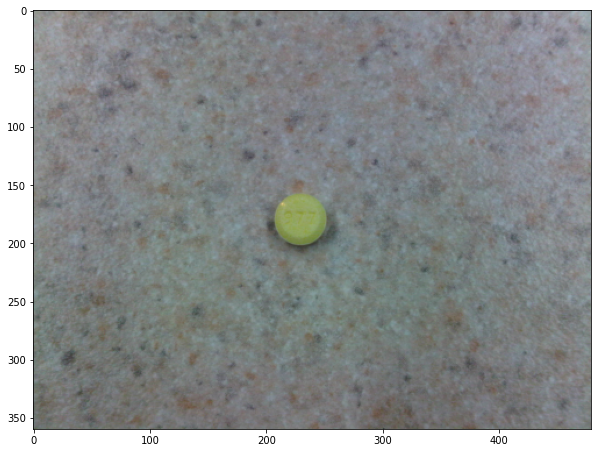

In [108]:
image_orig = io.imread(os.path.join(images_dir, filename))
# image = image_orig
image = transform.resize(image_orig, (int(image_orig.shape[0] * (480 / image_orig.shape[1])), 480), anti_aliasing=True)
#image = color.rgba2rgb(image)
plt.figure(figsize=(10,10))
plt.imshow(image)
print(image.shape)

Estimated Gaussian noise standard deviation = 0.007524798660230995


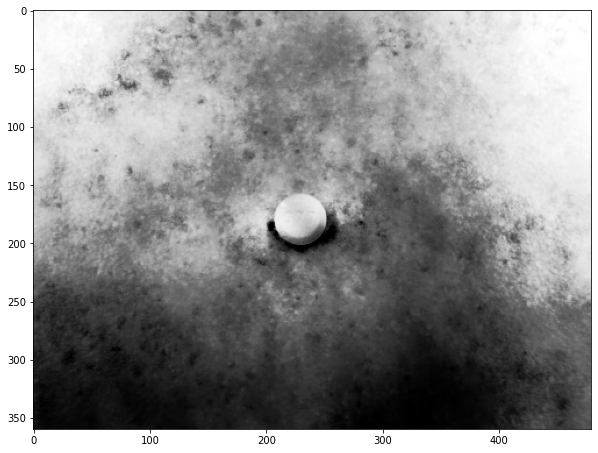

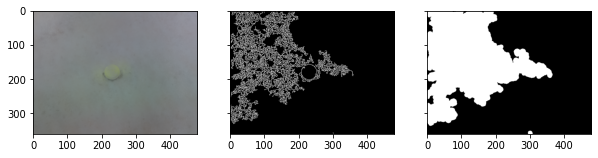

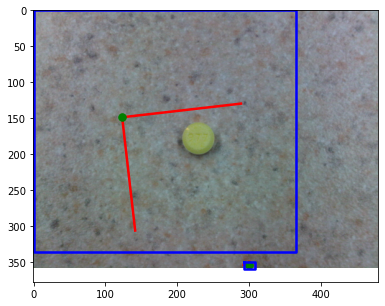

In [109]:
from skimage.restoration import denoise_bilateral, estimate_sigma
from skimage import segmentation, exposure, morphology

sigma_est = estimate_sigma(image, multichannel=True, average_sigmas=True)

print(f"Estimated Gaussian noise standard deviation = {sigma_est}")
bilat = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, multichannel=True)

bilat_gs = color.rgb2gray(bilat)

img_eq = exposure.equalize_hist(bilat_gs)
fig = plt.figure(figsize=(10,8))
plt.imshow(img_eq, cmap='gray')

# apply threshold
thresh = filters.threshold_otsu(img_eq)
bw = morphology.closing(img_eq < thresh, morphology.disk(3))

# remove artifacts connected to image border
cleared = segmentation.clear_border(bw)

edges = feature.canny(bilat_gs, sigma=sigma_est, low_threshold=0, high_threshold=0.1)


fig, ax = plt.subplots(1,3,figsize=(10,10),sharey=True)

ax[0].imshow(bilat)

ax[1].imshow(edges, cmap='gray')

selem = disk(6)

dilated = dilation(edges, selem)

filled = ndi.binary_fill_holes(dilated)

ax[2].imshow(filled, cmap='gray')

label_img = label(filled)
regions = regionprops(label_img)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

plt.show()

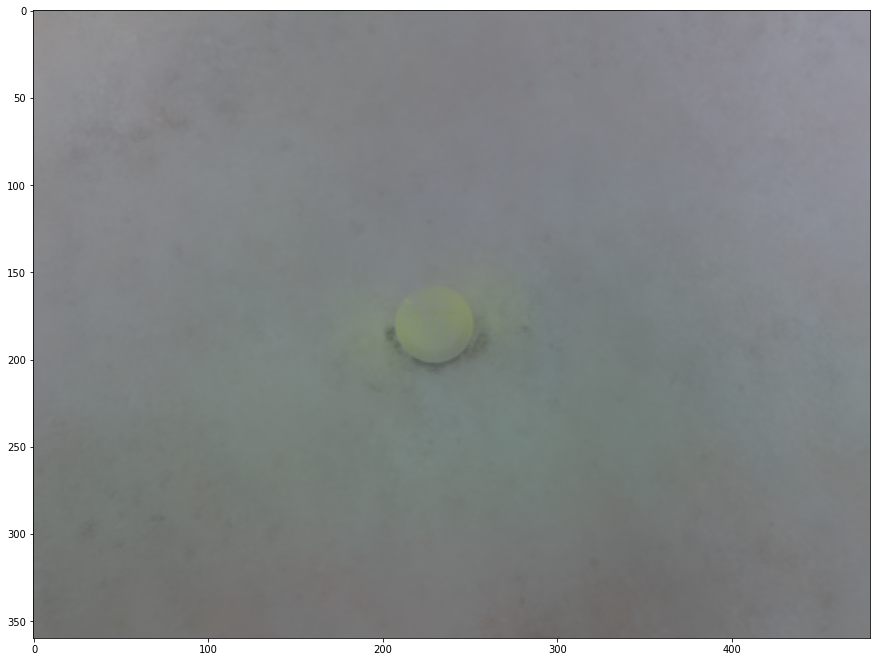

In [107]:
plt.figure(figsize=(15,15))
plt.imshow(bilat)

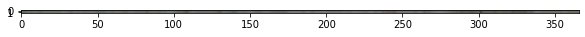

In [110]:
minr, minc, maxr, maxc = regions[1].bbox
minr1, minc1, maxr1, maxc1 = regions[0].bbox
cropped = image[min(minr,minr1)-int(0.2*(maxr-minr)):max(maxr,maxr1),min(minc,minc1):max(maxc,maxc1),:]
plt.figure(figsize=(10,10))
plt.imshow(cropped)

79 65 3
Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)
Predicting color indices on the full image (random)


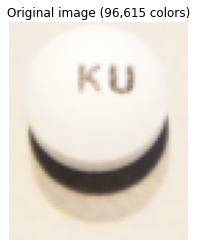

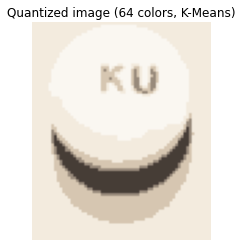

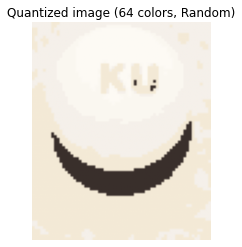

In [93]:
# K MEANS

img = image

n_colors = 5
image = cropped
# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
print(w,h,d)
assert d == 3
image_array = np.reshape(image, (w * h, d))

print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")

labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)

def recreate_image(codebook, labels, w, h):
    # Recreate the (compressed) image from the code book & labels
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
image_knn = recreate_image(kmeans.cluster_centers_, labels, w, h)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

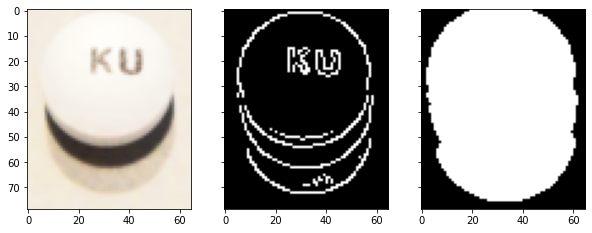

In [103]:
edges = feature.canny(color.rgb2gray(cropped), sigma=sigma_est, low_threshold=0, high_threshold=0.1)


fig, ax = plt.subplots(1,3,figsize=(10,10),sharey=True)

ax[0].imshow(cropped)

ax[1].imshow(edges, cmap='gray')

selem = disk(3)

dilated = dilation(edges, selem)

filled = ndi.binary_fill_holes(dilated)

ax[2].imshow(filled, cmap='gray')


/home/mirko/Envs/pill-classification/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  from ipykernel import kernelapp as app


(79, 65, 3)
(64, 64)


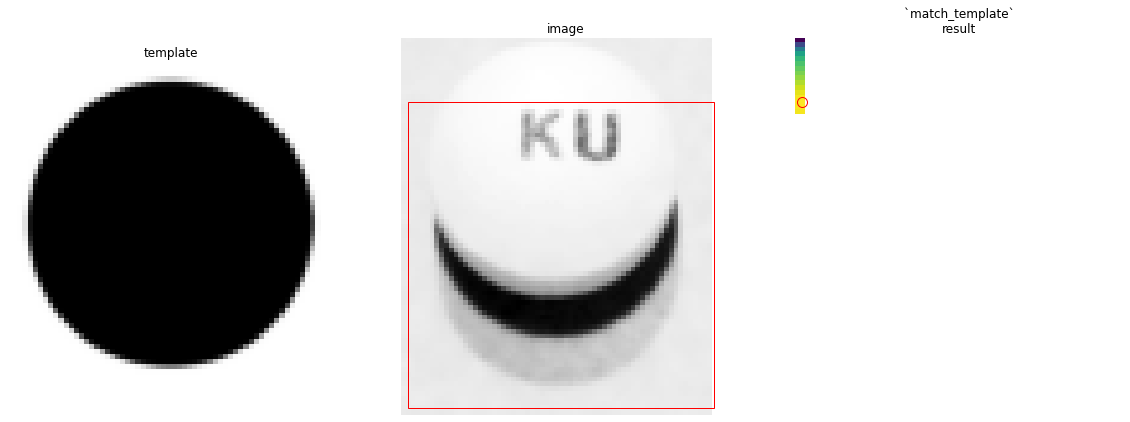

In [100]:
# TEMPLATE MATCHING

import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import match_template

template = io.imread(os.path.join(images_dir, 'circle.png'))

img = cropped
w, h, d = original_shape = tuple(img.shape)

template = transform.resize(template, (int(template.shape[0] * (64 / template.shape[1])), 64), anti_aliasing=True)
img_gs = color.rgb2gray(img)
template = color.rgb2gray(template)
print(cropped.shape)
print(template.shape)

result = match_template(img_gs, template)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(template, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img_gs, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = template.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

384 480 3
Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)
Predicting color indices on the full image (random)


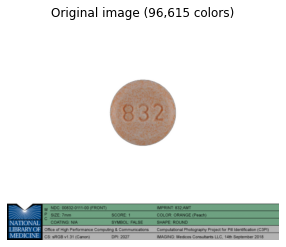

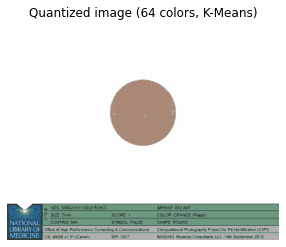

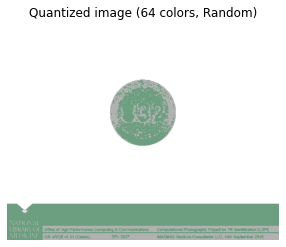

In [23]:
# K MEANS

n_colors = 6

image = np.array(image_orig, dtype=np.float64) / 255
image = transform.resize(image, (int(image_orig.shape[0] * (480 / image_orig.shape[1])), 480), anti_aliasing=True)

image = color.rgba2rgb(image)
# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
print(w,h,d)
assert d == 3
image_array = np.reshape(image, (w * h, d))

print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")

labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)

def recreate_image(codebook, labels, w, h):
    # Recreate the (compressed) image from the code book & labels
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
image_knn = recreate_image(kmeans.cluster_centers_, labels, w, h)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

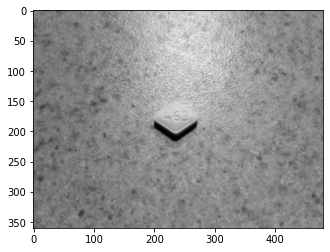

In [72]:
image_gs = color.rgb2gray(image)
plt.imshow(image_gs, cmap='gray')

[[0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 ...
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]
 [0.45644471 0.45644471 0.45644471 ... 0.45644471 0.45644471 0.45644471]]


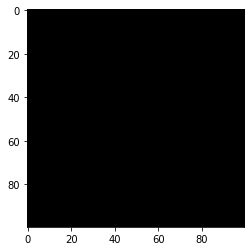

In [45]:
from skimage import io, img_as_float, filters, morphology, img_as_ubyte

a = 100
b = 100 + a
bg = img_as_float(image_gs[a:b, a:b])

bg = img_as_float(filters.rank.mean(img_as_ubyte(bg), selem=morphology.square(3)))

bg_avg = bg.copy()
bg_avg[:,:] = np.mean(bg, axis=(0,1))

print(bg_avg)

plt.imshow(bg_avg, cmap='gray')

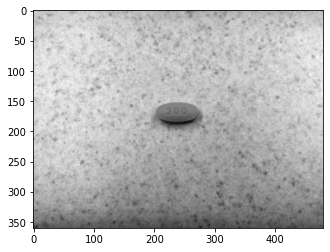

In [52]:

plt.imshow(image_gs, cmap='gray')

<Figure size 720x576 with 0 Axes>

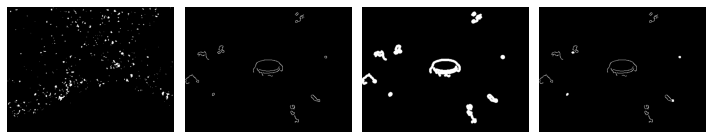

In [50]:
thresh = filters.threshold_otsu(image_gs)

bw = closing(image_gs <= thresh, square(3))

# remove artifacts connected to image border
cleared = segmentation.clear_border(bw)

# edges = filters.sobel(cleared)
edges = feature.canny(image_gs, sigma=2, low_threshold=0, high_threshold=0.1)
plt.figure(figsize=(10,8))

selem = disk(3)

dilated = dilation(edges, selem)

filled = ndi.binary_fill_holes(edges)

fig, axes = plt.subplots(1, 4, figsize=(10,10), sharey=True)
axes[0].imshow(cleared, cmap='gray')
axes[1].imshow(edges, cmap='gray')
axes[2].imshow(dilated, cmap='gray')
axes[3].imshow(filled, cmap='gray')

for a in axes:
    a.axis('off')

plt.tight_layout()

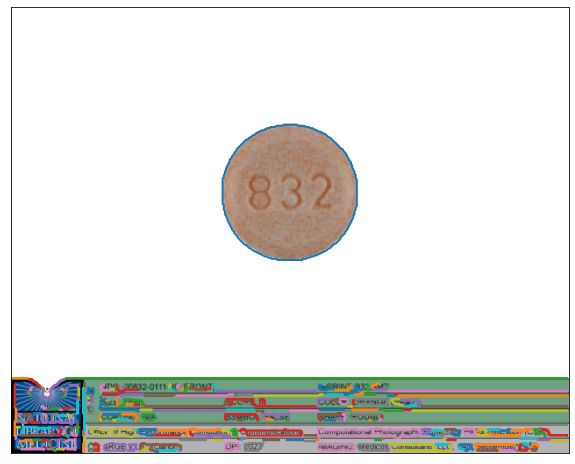

In [26]:
# Find contours at a constant value of 0.8
contours = find_contours(filled, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()